# 🔌 Transformer Seq2Point for HeatPump (15min Resolution)

This notebook implements a **Convolutional Transformer Encoder** architecture for energy disaggregation of a Heat Pump using 15-minute interval data.

**Key Features:**
- **Architecture:** Hybrid Conv1D + Transformer Encoder.
- **Task:** **Seq2Point** (mapping a window of aggregate consumption to the appliance consumption at the center point).
- **Resolution:** 15 minutes.
- **Optimization:** MSE Loss + AdamW Optimizer with Learning Rate Scheduler.

### 1. Import Required Libraries

In [1]:
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.preprocessing import StandardScaler
import os
import pickle
import math
import warnings
warnings.filterwarnings("ignore")

# Global Device Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


### 2. Configuration and Hyperparameters

In [2]:
# ===== CONFIGURATION =====
APPLIANCE = 'heatpump'
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 100
SEQ_LEN = 99
INPUT_DIM = 7
D_MODEL = 256
N_HEADS = 32
N_LAYERS = 8
DIM_FEEDFORWARD = 512
DROPOUT = 0.25
PATIENCE = 15

# Classification & Loss Config
ON_THRESHOLD = 0.1  # Threshold to define ON state (in scaled space)
CLF_WEIGHT = 0.5    # Weight for the classification loss in total loss

# Path to the data
DATA_BASE_PATH = os.path.join("..", "data", "processed", "15min", "model_ready", APPLIANCE)
if not os.path.exists(DATA_BASE_PATH):
    DATA_BASE_PATH = os.path.join("..", ".tmp", "data", "processed", "15min", "model_ready", APPLIANCE)

print(f"Data path selected: {DATA_BASE_PATH}")

Data path selected: ..\.tmp\data\processed\15min\model_ready\heatpump


### 3. Data Loading and Feature Engineering

In [3]:
def load_and_verify_data(path):
    x_train = np.load(os.path.join(path, "X_train.npy"))
    y_train = np.load(os.path.join(path, "y_train.npy"))
    x_val = np.load(os.path.join(path, "X_val.npy"))
    y_val = np.load(os.path.join(path, "y_val.npy"))
    x_test = np.load(os.path.join(path, "X_test.npy"))
    y_test = np.load(os.path.join(path, "y_test.npy"))
    return x_train, y_train, x_val, y_val, x_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_and_verify_data(DATA_BASE_PATH)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

X_train: (24094, 99, 7), y_train: (24094, 99, 1)


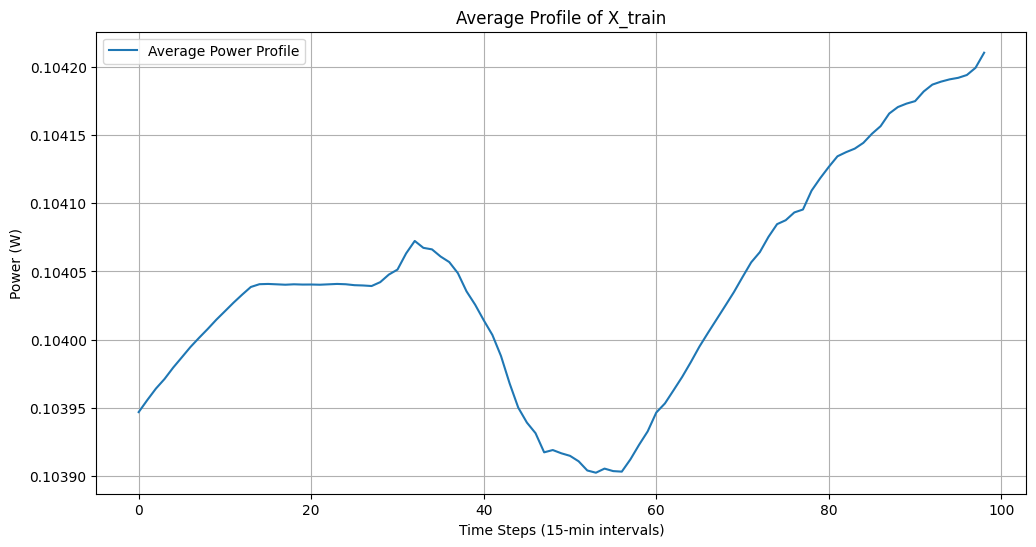

In [4]:
X_mean_profile = np.mean(X_train, axis=0)
X_std_profile = np.std(X_train, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(X_mean_profile[:, 0], label='Average Power Profile')
plt.xlabel('Time Steps (15-min intervals)')
plt.ylabel('Power (W)')
plt.title('Average Profile of X_train')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
X_mean_profile[:, 0]

array([0.10394691, 0.10395575, 0.10396416, 0.10397121, 0.10397953,
       0.10398704, 0.10399461, 0.10400134, 0.10400781, 0.10401462,
       0.10402085, 0.10402714, 0.10403302, 0.1040386 , 0.10404065,
       0.10404083, 0.10404056, 0.10404027, 0.10404057, 0.10404038,
       0.10404041, 0.10404027, 0.10404055, 0.10404084, 0.10404061,
       0.10403993, 0.10403971, 0.10403931, 0.10404215, 0.10404771,
       0.10405135, 0.10406321, 0.10407234, 0.10406729, 0.10406616,
       0.10406091, 0.10405687, 0.10404875, 0.10403544, 0.10402564,
       0.1040142 , 0.10400346, 0.10398798, 0.10396791, 0.10395017,
       0.10393924, 0.10393148, 0.10391743, 0.10391911, 0.10391671,
       0.10391486, 0.10391085, 0.10390414, 0.10390249, 0.10390551,
       0.10390367, 0.10390329, 0.10391227, 0.10392291, 0.10393278,
       0.10394662, 0.10395326, 0.10396292, 0.10397271, 0.10398352,
       0.10399494, 0.10400508, 0.10401498, 0.10402488, 0.1040349 ,
       0.10404593, 0.10405667, 0.10406413, 0.10407531, 0.10408

In [6]:
X_mean_profile[0]

array([0.10394691, 0.4999821 , 0.4999631 , 0.50199616, 0.47420123,
       0.48413172, 0.49990326], dtype=float32)

### 4. Dataset and DataLoader Creation

In [7]:
class NILMDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(NILMDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(NILMDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(NILMDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightedNILMLoss(nn.Module):
    """
    Custom weighted loss function for NILM tasks.
    Combines MSE and MAE with class-weighted penalties to handle 
    the imbalanced nature of appliance ON/OFF states.
    """
    def __init__(self, on_weight=15.0, off_weight=1.0, threshold=0.01, mix_ratio=0.5, fn_weight=10.0):
        """
        Args:
            on_weight (float): Weight for errors when appliance is ON (higher = more penalty).
            off_weight (float): Weight for errors when appliance is OFF.
            threshold (float): Threshold to consider appliance as ON (in scaled space).
            mix_ratio (float): 0.0 = MSE only, 1.0 = MAE only. 0.5 is a good balance.
            fn_weight (float): Extra multiplier for False Negatives (Predict OFF but actually ON).
        """
        super(WeightedNILMLoss, self).__init__()
        self.on_weight = on_weight
        self.off_weight = off_weight
        self.threshold = threshold
        self.mix_ratio = mix_ratio
        self.fn_weight = fn_weight

    def forward(self, pred, target):
        # 1. Handle dimension mismatch
        if pred.shape != target.shape:
            target = target.view_as(pred)

        # 2. Compute base errors (element-wise)
        # MSE (L2) penalizes large errors heavily (good for peaks)
        mse_loss = F.mse_loss(pred, target, reduction='none')
        # MAE (L1) promotes sparsity and helps push small values to zero
        l1_loss = F.l1_loss(pred, target, reduction='none')
        
        # Hybrid combination
        combined_loss = (1 - self.mix_ratio) * mse_loss + self.mix_ratio * l1_loss

        # 3. Create ON/OFF masks
        on_mask = torch.abs(target) > self.threshold
        
        # Identify False Negatives: Target is ON but Prediction is OFF (<= threshold)
        # This is the "Predicts OFF but is ON" case user wants to penalize more
        fn_mask = on_mask & (torch.abs(pred) <= self.threshold)
        
        # 4. Apply class weights
        weights = torch.ones_like(combined_loss) * self.off_weight
        weights[on_mask] = self.on_weight
        
        # 5. Apply extra penalty for False Negatives
        weights[fn_mask] *= self.fn_weight

        # 6. Return weighted mean loss
        return (combined_loss * weights).mean()

### 5. Transformer Model Architecture

In [9]:
import torch
import torch.nn as nn
import math

class ImprovedPositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for temporal sequence modeling."""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :]


class MultiTaskNILMTransformer(nn.Module):
    """
    Multi-task Transformer for Non-Intrusive Load Monitoring (NILM).
    
    Architecture:
        1. Conv1D embedding for local feature extraction
        2. Positional encoding for temporal awareness
        3. Transformer encoder for global context
        4. Dual output heads: regression (power) + classification (ON/OFF)
    
    The classification head acts as a "gate" during inference to set 
    power to zero when the appliance is predicted to be OFF.
    """
    def __init__(self, input_dim, d_model, n_heads, n_layers, seq_len, ff_dim, dropout=0.1, gate_threshold=0.5):
        super().__init__()
        self.gate_threshold = gate_threshold
        
        # 1. FEATURE EXTRACTION (Conv1d for local patterns)
        self.conv_embedding = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=d_model, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 2. POSITIONAL ENCODING
        self.pos_encoding = ImprovedPositionalEncoding(d_model, max_len=seq_len)
        
        # 3. TRANSFORMER ENCODER
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=ff_dim, 
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # 4. OUTPUT HEADS
        # Regression head (Power estimation)
        self.regression_head = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Classification head (ON/OFF state)
        self.classification_head = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Args:
            x: Input tensor [Batch, Seq_Len, Features]
        Returns:
            Training: (raw_power, on_off_prob) for separate loss computation
            Inference: (gated_power, on_off_prob) with automatic zero-gating
        """
        # A. Feature Extraction & Transformer
        x = x.permute(0, 2, 1)  # [B, F, S] for Conv1d
        x = self.conv_embedding(x)
        x = x.permute(0, 2, 1)  # [B, S, D] for Transformer
        
        x = self.pos_encoding(x)
        x = self.transformer_encoder(x)
        
        # B. Seq2Point: Focus on midpoint token
        mid_token = x[:, x.shape[1] // 2, :]
        
        # C. Compute outputs
        raw_power = self.regression_head(mid_token)
        on_off_prob = self.classification_head(mid_token)
        
        # D. Apply gating during inference
        if not self.training:
            is_on = (on_off_prob > self.gate_threshold).float()
            final_power = raw_power * is_on  # Zero power when OFF
            return final_power, on_off_prob
        
        return raw_power, on_off_prob

### 5.1 Model Instantiation and Summary

In [10]:
# Initialize the model with configured hyperparameters
model = MultiTaskNILMTransformer(
    input_dim=INPUT_DIM,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    seq_len=SEQ_LEN,
    ff_dim=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(DEVICE)

# Model summary: count trainable parameters
def count_parameters(model):
    """Count total and trainable parameters in the model."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = count_parameters(model)
print(f"Model Architecture: ConvNILMTransformer")
print(f"Total Parameters: {total:,}")
print(f"Trainable Parameters: {trainable:,}")
print(f"Model moved to: {DEVICE}")

Model Architecture: ConvNILMTransformer
Total Parameters: 4,259,586
Trainable Parameters: 4,259,586
Model moved to: cuda


### 6. Training Loop

In [11]:
# Loss functions and optimizer
# fn_weight=10.0 penalizes False Negatives (Predict OFF but is ON) 10x more than standard ON errors
criterion = WeightedNILMLoss(
    on_weight=30.0, 
    off_weight=5.0, 
    threshold=ON_THRESHOLD, 
    mix_ratio=0.5,
    fn_weight=15.0 
)
criterion_clf = nn.BCELoss() # Binary Cross Entropy for ON/OFF classification

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler: reduces LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

In [12]:
# Initialize tracking variables
best_val_loss = float('inf')
epochs_without_improvement = 0
train_losses = []
val_losses = []

print(f"Starting training for {EPOCHS} epochs...")
print(f"Early stopping patience: {PATIENCE} epochs")
print("-" * 60)

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    train_loss, train_loss_reg, train_loss_clf = 0, 0, 0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        
        # Forward pass
        pred_power, prob_on = model(x_batch)
        
        # Prepare targets (Seq2Point)
        midpoint = y_batch.shape[1] // 2
        target_power = y_batch[:, midpoint].view(-1, 1)
        target_on_off = (torch.abs(target_power) > ON_THRESHOLD).float()
        
        # Compute losses
        loss_reg = criterion(pred_power, target_power)
        loss_clf = criterion_clf(prob_on, target_on_off)
        total_loss = loss_reg + (CLF_WEIGHT * loss_clf)
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += total_loss.item()
        train_loss_reg += loss_reg.item()
        train_loss_clf += loss_clf.item()

    # --- Validation Phase ---
    model.eval()
    val_loss, val_loss_reg, val_loss_clf = 0, 0, 0
    
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            pred_power_gated, prob_on = model(x_batch)
            
            midpoint = y_batch.shape[1] // 2
            target_power = y_batch[:, midpoint].view(-1, 1)
            target_on_off = (torch.abs(target_power) > ON_THRESHOLD).float()
            
            v_loss_reg = criterion(pred_power_gated, target_power)
            v_loss_clf = criterion_clf(prob_on, target_on_off)
            
            val_loss += (v_loss_reg + CLF_WEIGHT * v_loss_clf).item()
            val_loss_reg += v_loss_reg.item()
            val_loss_clf += v_loss_clf.item()

    # --- Calculate averages and log ---
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1:03d}/{EPOCHS} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | LR: {current_lr:.2e}")

    # --- Early Stopping & Model Saving ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), f"transformer_{APPLIANCE}_best.pth")
        print(f"  ✓ New best model saved!")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= PATIENCE:
            print(f"\n⚠ Early stopping triggered after {epoch+1} epochs")
            break

print("-" * 60)
print(f"Training completed! Best validation loss: {best_val_loss:.6f}")

Starting training for 100 epochs...
Early stopping patience: 15 epochs
------------------------------------------------------------
Epoch 001/100 | Train: 3.2518 | Val: 19.6261 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 002/100 | Train: 2.0187 | Val: 14.3067 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 003/100 | Train: 1.7237 | Val: 14.9281 | LR: 1.00e-04
Epoch 004/100 | Train: 1.4513 | Val: 9.6359 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 005/100 | Train: 1.3595 | Val: 9.2461 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 006/100 | Train: 1.2768 | Val: 7.7844 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 007/100 | Train: 1.1751 | Val: 9.6053 | LR: 1.00e-04
Epoch 008/100 | Train: 1.1770 | Val: 5.3742 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 009/100 | Train: 1.0203 | Val: 7.4067 | LR: 1.00e-04
Epoch 010/100 | Train: 0.9061 | Val: 9.7951 | LR: 1.00e-04
Epoch 011/100 | Train: 0.8792 | Val: 9.4327 | LR: 1.00e-04
Epoch 012/100 | Train: 0.8500 | Val: 9.3384 | LR: 5.00e-05
E

### 6.1 Training History Visualization

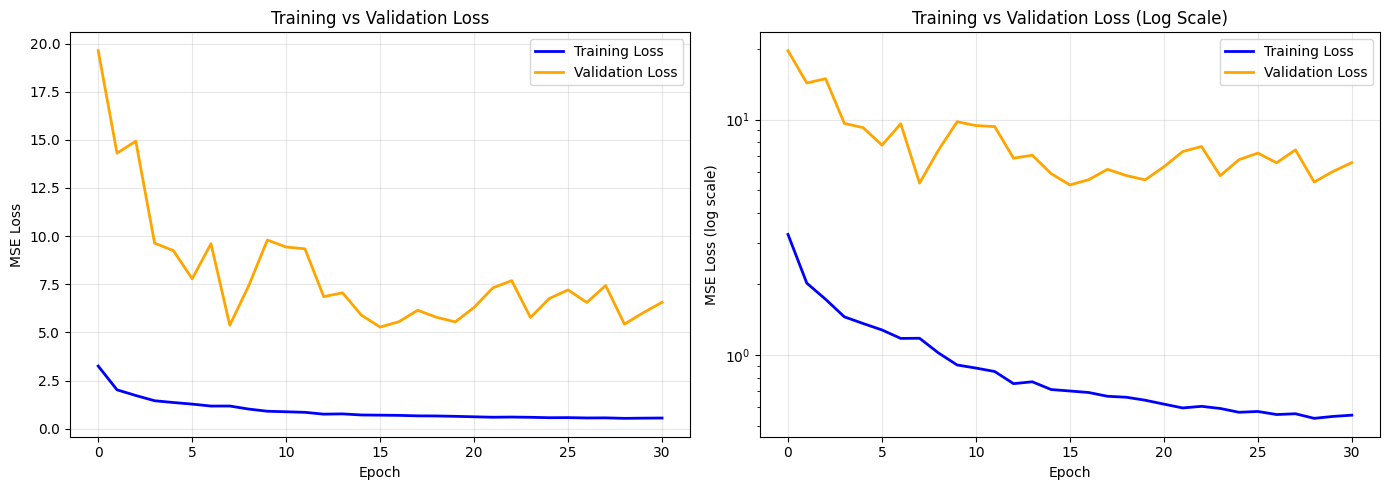


Training Summary:
  Initial Train Loss: 3.251789
  Final Train Loss: 0.554474
  Best Val Loss: 5.275596


In [13]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log scale for better visualization
axes[1].semilogy(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[1].semilogy(val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss (log scale)')
axes[1].set_title('Training vs Validation Loss (Log Scale)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTraining Summary:")
print(f"  Initial Train Loss: {train_losses[0]:.6f}")
print(f"  Final Train Loss: {train_losses[-1]:.6f}")
print(f"  Best Val Loss: {best_val_loss:.6f}")

### 7. Evaluation and Visualization

In [14]:
# Load the best model for evaluation
model.load_state_dict(torch.load(f"transformer_{APPLIANCE}_best.pth", weights_only=True))
model.eval() # Gating is active in eval mode!

# Collect all predictions and ground truth from test set
all_preds = []
all_probs = [] # Collect classification probabilities
all_true = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        
        # Forward pass (in eval mode returns: gated_power, prob_on)
        pred_power, prob_on = model(x_batch)
        
        preds = pred_power.cpu().numpy().squeeze()
        probs = prob_on.cpu().numpy().squeeze()
        
        # Extract the center point from the ground truth sequence (Seq2Point)
        seq_len = y_batch.shape[1]
        midpoint = seq_len // 2
        true = y_batch[:, midpoint].numpy()
        
        all_preds.append(preds)
        all_probs.append(probs)
        all_true.append(true)

# Concatenate all batches
all_preds = np.concatenate(all_preds, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_true = np.concatenate(all_true, axis=0)

print(f"Test set predictions shape: {all_preds.shape}")
print(f"Test set ground truth shape: {all_true.shape}")

Test set predictions shape: (5278,)
Test set ground truth shape: (5278, 1)


### 7.1 Quantitative Metrics

📊 EVALUATION METRICS - HEATPUMP

🔢 REGRESSION PERFORMANCE:
  MAE  (Mean Absolute Error):      0.0621
  RMSE (Root Mean Squared Error):  0.1614
  R²   (Coeff. of Determination):  0.6055
  NRMSE (Normalized RMSE):         1.1807
  SAE  (Signal Aggregate Error):   0.0789 (7.89%)

🔌 CLASSIFICATION PERFORMANCE (ON/OFF Detection):
  Accuracy:   0.9341
  F1 Score:   0.8762
  Precision:  0.8646
  Recall:     0.8882


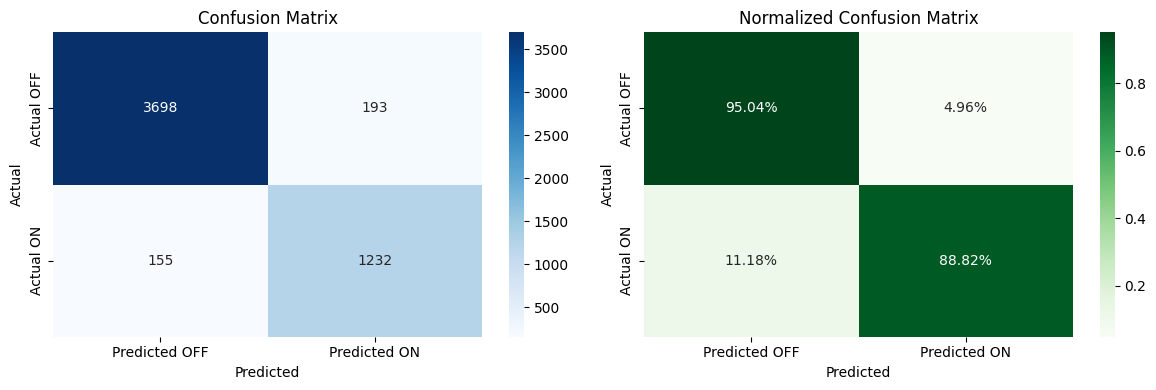


📈 Gating Statistics:
  Predicted OFF: 3,853 / 5,278 (73.0%)
  Predicted ON:  1,425 / 5,278 (27.0%)
  Mean |Power| when OFF: 0.000000 (should be ~0.0)


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Flatten arrays
preds_flat = all_preds.flatten()
true_flat = all_true.flatten()
probs_flat = all_probs.flatten()

# === REGRESSION METRICS ===
mae = mean_absolute_error(true_flat, preds_flat)
mse = mean_squared_error(true_flat, preds_flat)
rmse = np.sqrt(mse)
r2 = r2_score(true_flat, preds_flat)
mean_power = np.mean(np.abs(true_flat))
nrmse = rmse / mean_power if mean_power != 0 else float('inf')

# NILM-specific: Signal Aggregate Error (SAE) - measures total energy estimation accuracy
total_true_energy = np.sum(np.abs(true_flat))
total_pred_energy = np.sum(np.abs(preds_flat))
sae = np.abs(total_true_energy - total_pred_energy) / total_true_energy if total_true_energy > 0 else 0

# === CLASSIFICATION METRICS ===
binary_true = (np.abs(true_flat) > ON_THRESHOLD).astype(int)
binary_pred = (probs_flat > 0.5).astype(int)

acc = accuracy_score(binary_true, binary_pred)
prec = precision_score(binary_true, binary_pred, zero_division=0)
rec = recall_score(binary_true, binary_pred, zero_division=0)
f1 = f1_score(binary_true, binary_pred, zero_division=0)
cm = confusion_matrix(binary_true, binary_pred)

# === PRINT RESULTS ===
print("=" * 65)
print(f"📊 EVALUATION METRICS - {APPLIANCE.upper()}")
print("=" * 65)
print(f"\n🔢 REGRESSION PERFORMANCE:")
print(f"  MAE  (Mean Absolute Error):      {mae:.4f}")
print(f"  RMSE (Root Mean Squared Error):  {rmse:.4f}")
print(f"  R²   (Coeff. of Determination):  {r2:.4f}")
print(f"  NRMSE (Normalized RMSE):         {nrmse:.4f}")
print(f"  SAE  (Signal Aggregate Error):   {sae:.4f} ({sae*100:.2f}%)")
print(f"\n🔌 CLASSIFICATION PERFORMANCE (ON/OFF Detection):")
print(f"  Accuracy:   {acc:.4f}")
print(f"  F1 Score:   {f1:.4f}")
print(f"  Precision:  {prec:.4f}")
print(f"  Recall:     {rec:.4f}")
print("=" * 65)

# === CONFUSION MATRIX VISUALIZATION ===
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Predicted OFF', 'Predicted ON'],
            yticklabels=['Actual OFF', 'Actual ON'])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Predicted OFF', 'Predicted ON'],
            yticklabels=['Actual OFF', 'Actual ON'])
axes[1].set_title('Normalized Confusion Matrix')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# === GATING EFFECTIVENESS CHECK ===
off_count = np.sum(binary_pred == 0)
on_count = np.sum(binary_pred == 1)
print(f"\n📈 Gating Statistics:")
print(f"  Predicted OFF: {off_count:,} / {len(binary_pred):,} ({off_count/len(binary_pred)*100:.1f}%)")
print(f"  Predicted ON:  {on_count:,} / {len(binary_pred):,} ({on_count/len(binary_pred)*100:.1f}%)")

off_idx = (binary_pred == 0)
if np.any(off_idx):
    mean_off_power = np.mean(np.abs(preds_flat[off_idx]))
    print(f"  Mean |Power| when OFF: {mean_off_power:.6f} (should be ~0.0)")

### 7.2 Prediction Visualization

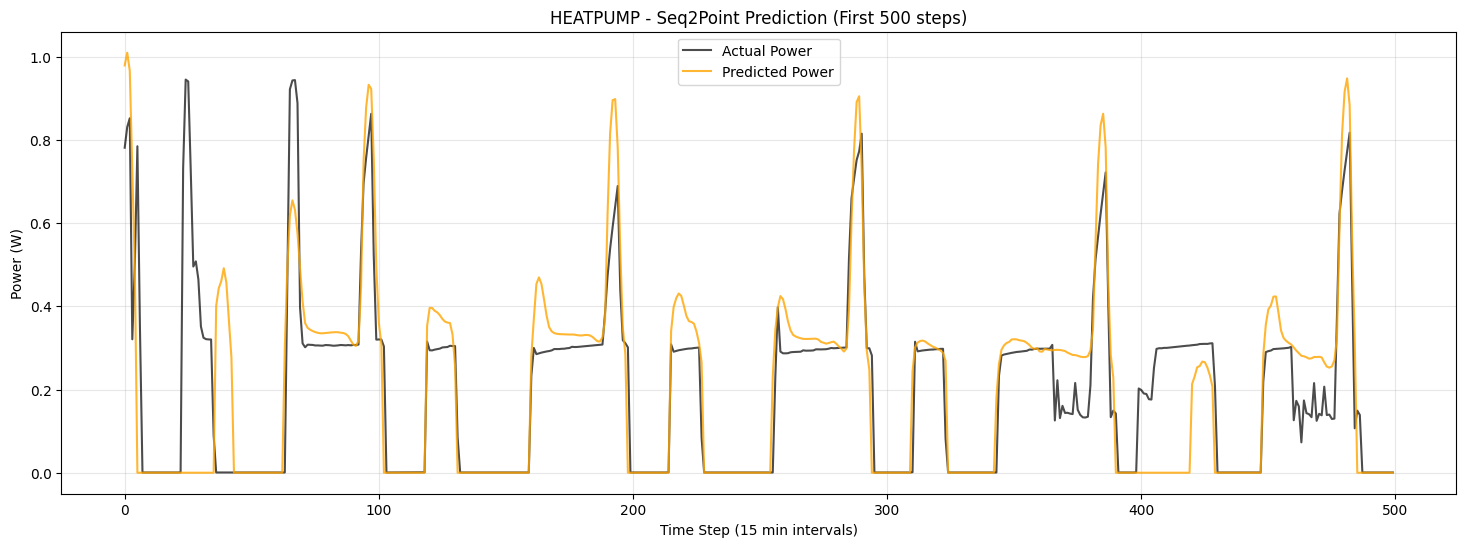

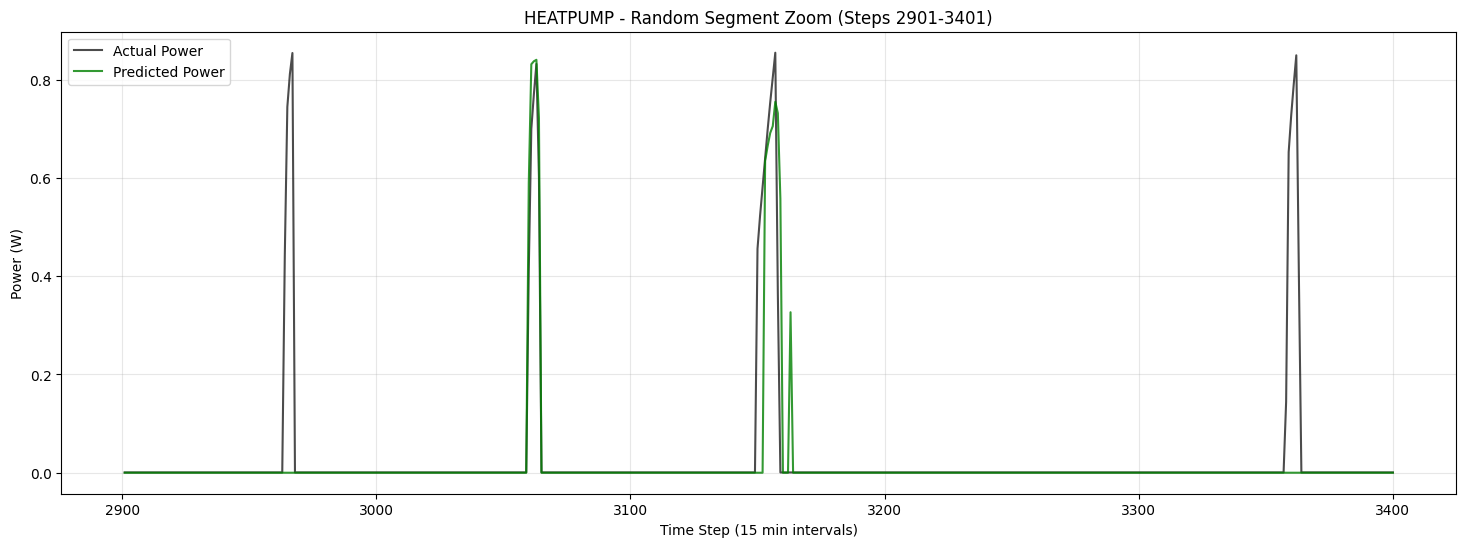

In [16]:
# Visualize a segment of the prediction vs actual
# Assuming test data is sequential (sliding window), we can plot the reconstructed signal.

# Select a window to zoom in (e.g., 500 steps ~ 5 days at 15min resolution)
start_idx = 0
end_idx = 500 

# Ensure we have enough data
if len(all_true) < end_idx:
    end_idx = len(all_true)

plt.figure(figsize=(18, 6))
plt.plot(all_true[start_idx:end_idx], label='Actual Power', color='black', alpha=0.7)
plt.plot(all_preds[start_idx:end_idx], label='Predicted Power', color='orange', alpha=0.8)
plt.title(f'{APPLIANCE.upper()} - Seq2Point Prediction (First {end_idx} steps)')
plt.xlabel('Time Step (15 min intervals)')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# If the test set is large, let's also show a random zoomed-in segment
if len(all_true) > 1000:
    random_start = np.random.randint(0, len(all_true) - 500)
    random_end = random_start + 500
    
    plt.figure(figsize=(18, 6))
    plt.plot(range(random_start, random_end), all_true[random_start:random_end], label='Actual Power', color='black', alpha=0.7)
    plt.plot(range(random_start, random_end), all_preds[random_start:random_end], label='Predicted Power', color='green', alpha=0.8)
    plt.title(f'{APPLIANCE.upper()} - Random Segment Zoom (Steps {random_start}-{random_end})')
    plt.xlabel('Time Step (15 min intervals)')
    plt.ylabel('Power (W)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### 7.3 Residual Analysis and Error Distribution

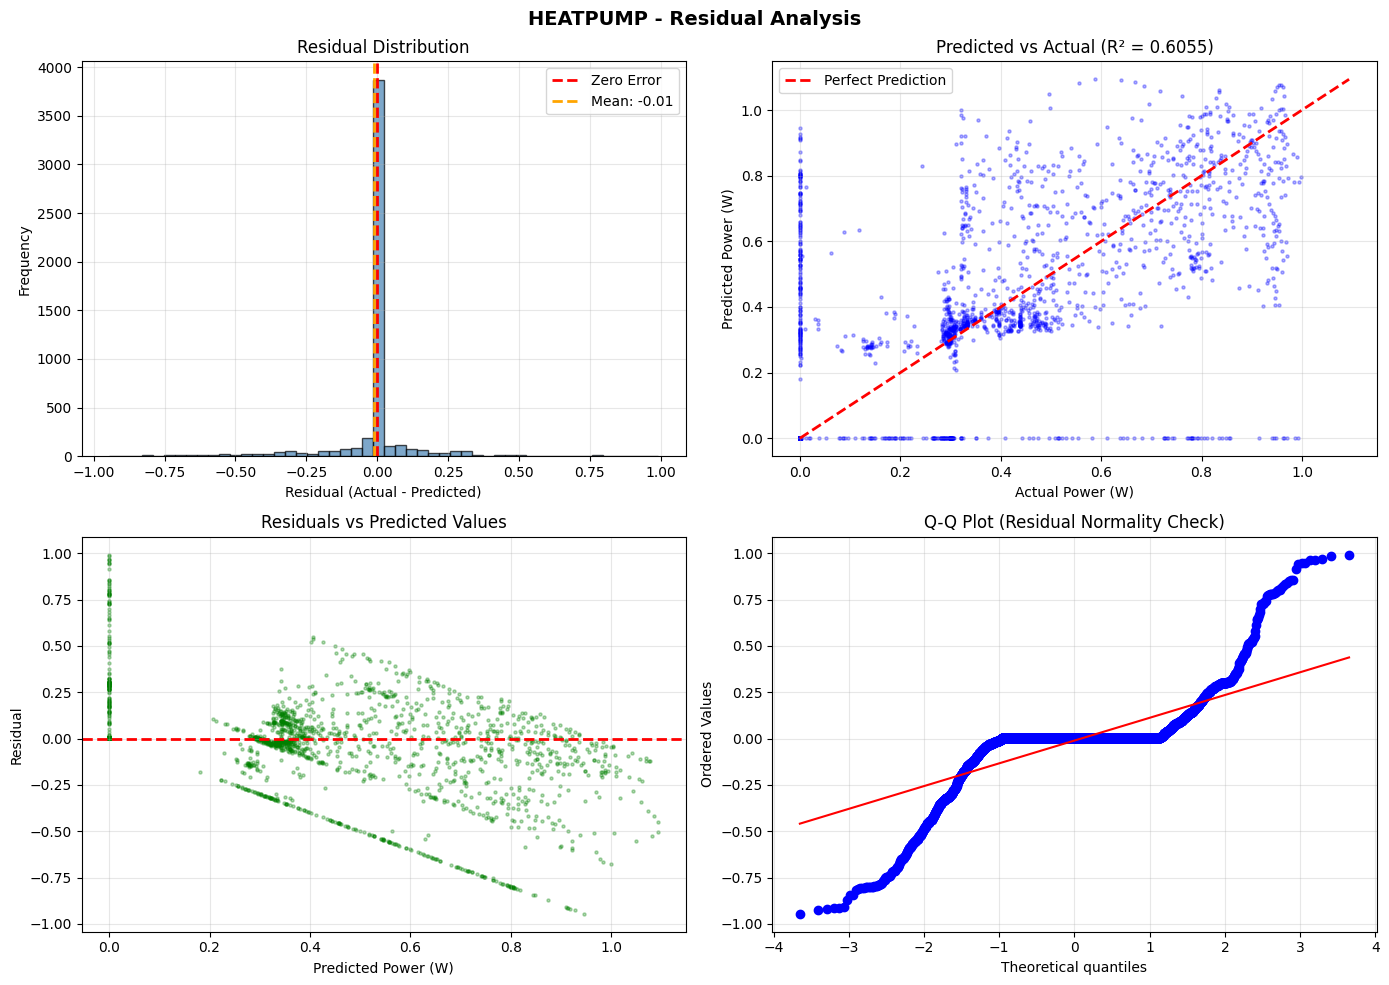


Residual Statistics:
  Mean Residual: -0.0108 W (should be ~0)
  Std Residual:  0.1610 W
  Skewness:      -0.6057
  Kurtosis:      11.9340


In [17]:
# Residual analysis
residuals = true_flat - preds_flat

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residual distribution (histogram)
axes[0, 0].hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 0].axvline(x=np.mean(residuals), color='orange', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals):.2f}')
axes[0, 0].set_xlabel('Residual (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Residual Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Predicted vs Actual scatter plot
axes[0, 1].scatter(true_flat, preds_flat, alpha=0.3, s=5, color='blue')
max_val = max(true_flat.max(), preds_flat.max())
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Power (W)')
axes[0, 1].set_ylabel('Predicted Power (W)')
axes[0, 1].set_title(f'Predicted vs Actual (R² = {r2:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals vs Predicted (check for heteroscedasticity)
axes[1, 0].scatter(preds_flat, residuals, alpha=0.3, s=5, color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Power (W)')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('Residuals vs Predicted Values')
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q plot for normality check
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Residual Normality Check)')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'{APPLIANCE.upper()} - Residual Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print residual statistics
print(f"\nResidual Statistics:")
print(f"  Mean Residual: {np.mean(residuals):.4f} W (should be ~0)")
print(f"  Std Residual:  {np.std(residuals):.4f} W")
print(f"  Skewness:      {stats.skew(residuals):.4f}")
print(f"  Kurtosis:      {stats.kurtosis(residuals):.4f}")

### 8. Conclusions and Next Steps

**Summary:**
This notebook implemented a **Multi-Task Convolutional NILM Transformer** for energy disaggregation with the following key features:

1. **Hybrid Architecture**: Conv1D embedding for local pattern extraction + Transformer encoder for global context
2. **Multi-Task Learning**: Joint regression (power estimation) and classification (ON/OFF detection)
3. **Intelligent Gating**: Classification head acts as a gate during inference to zero-out power when OFF
4. **Weighted Loss Function**: Custom loss that penalizes ON-state errors more heavily to handle class imbalance
5. **Robust Training**: Early stopping, LR scheduler, and gradient clipping for stable convergence

**Key Metrics:**
- **SAE (Signal Aggregate Error)**: Measures total energy estimation accuracy - important for billing applications
- **F1 Score**: Balances precision/recall for ON/OFF detection
- **R²**: Overall regression quality

**Potential Improvements:**
- 🔍 **Attention Visualization**: Add hooks to visualize which time steps the model focuses on
- 📊 **Threshold Tuning**: Experiment with different `gate_threshold` values for optimal precision/recall trade-off
- 🔄 **Data Augmentation**: Add noise injection, time warping, or mixup for better generalization
- 🏗️ **Architecture Variants**: Try different kernel sizes, deeper heads, or cross-attention mechanisms
- 📈 **Multi-Appliance**: Extend to predict multiple appliances simultaneously